<font face="Chalkboard" color="darkgreen" size=5> Locally Weighted Linear Regression - Making Predictions</font>

In [ ]:
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [ ]:
# Tricubic Kernel
def tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

In [ ]:
# Epanechnikov Kernel - is perhaps one of the best choices
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

In [ ]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2) 

In [ ]:
#Defining the kernel function - used for plotting later on


def lowess_kern(x, y, kern, tau):

    # tau is called bandwidth K((x-x[i])/(2*tau))

    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the kernel function by using only the train data    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Boston Housing Prices.csv')

In [ ]:
df

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Winthrop,1801,-70.986000,42.231201,0.06263,0.0,11.93,no,0.573,6.593,69.099998,2.4786,1,273,21.000000,9.67,22.400000
502,Winthrop,1802,-70.990997,42.227501,0.04527,0.0,11.93,no,0.573,6.120,76.699997,2.2875,1,273,21.000000,9.08,20.600000
503,Winthrop,1803,-70.994797,42.226002,0.06076,0.0,11.93,no,0.573,6.976,91.000000,2.1675,1,273,21.000000,5.64,23.900000
504,Winthrop,1804,-70.987503,42.223999,0.10959,0.0,11.93,no,0.573,6.794,89.300003,2.3889,1,273,21.000000,6.48,22.000000


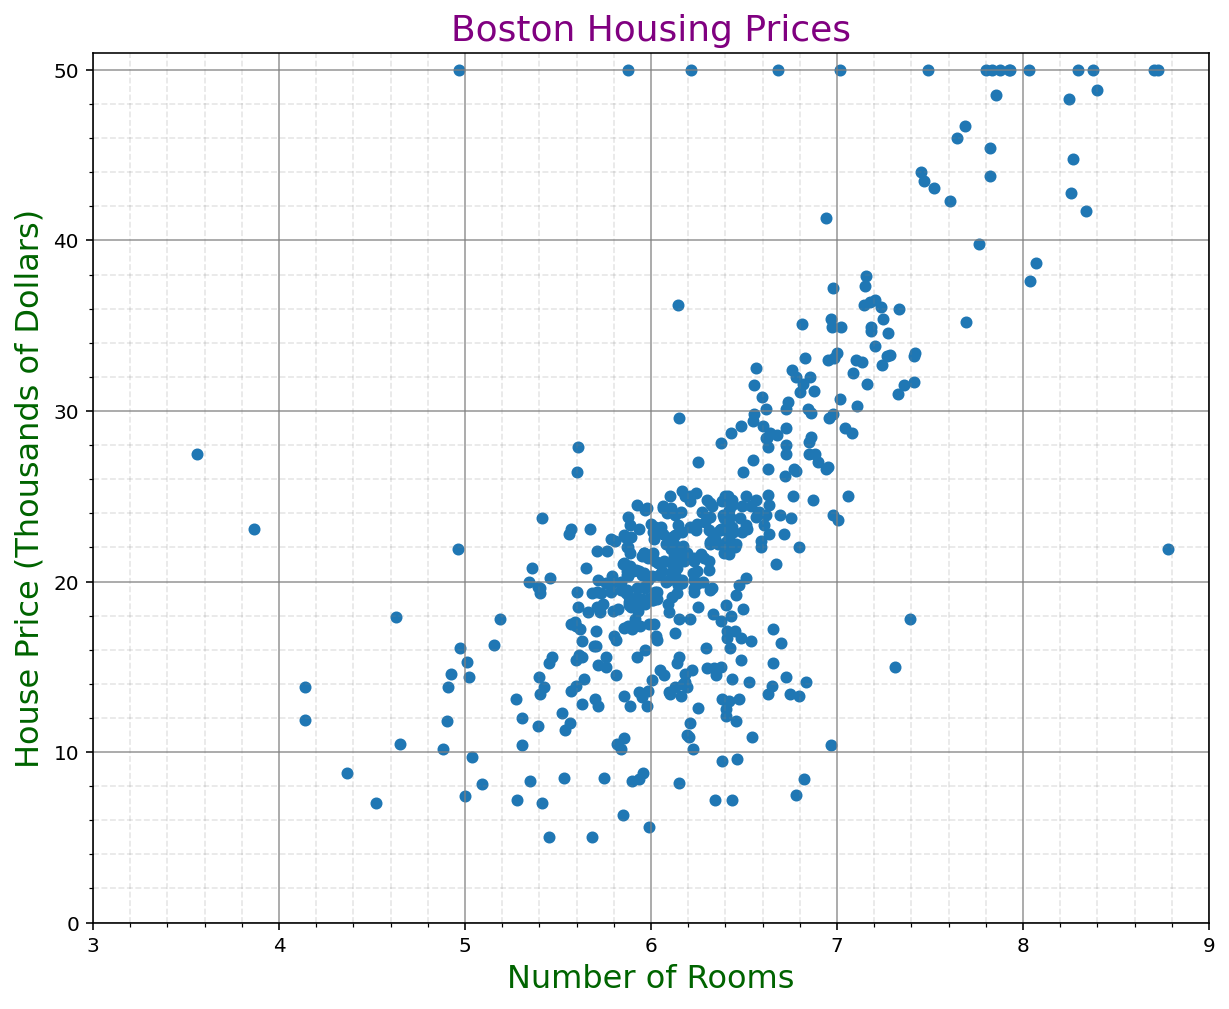

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [ ]:
df

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = np.array(df['rooms']).reshape(-1,1)
y = np.array(df['cmedv']).reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## We need the input data to be sorted for using LOWESS

In [ ]:
dat = np.concatenate([X_train,y_train.reshape(-1,1)], axis=1)

# this is sorting the rows based on the first column
dat = dat[np.argsort(dat[:, 0])]

dat_test = np.concatenate([X_test,y_test.reshape(-1,1)], axis=1)
dat_test = dat_test[np.argsort(dat_test[:, 0])]

In [ ]:
Yhat_lowess = lowess_kern(dat[:,0],dat[:,1],Epanechnikov,0.6)

In [ ]:
datl = np.concatenate([dat[:,0].reshape(-1,1),Yhat_lowess.reshape(-1,1)], axis=1)

## Also do not forget to predict on the Test set !!

In [ ]:
f = interp1d(datl[:,0], datl[:,1],fill_value='extrapolate')

yhat = f(dat_test[:,0])

### As a metric, for comparison we can use Mean Absolute Deviation

$$
\text{MAE}:=\frac{1}{n}\sum_{i=1}^{n}|y_i-\hat{y}_i|
$$

Intercept: -36.576
Coefficient: 9.429
MAE = $4,109.44
MAE LOWESS = $3,755.27


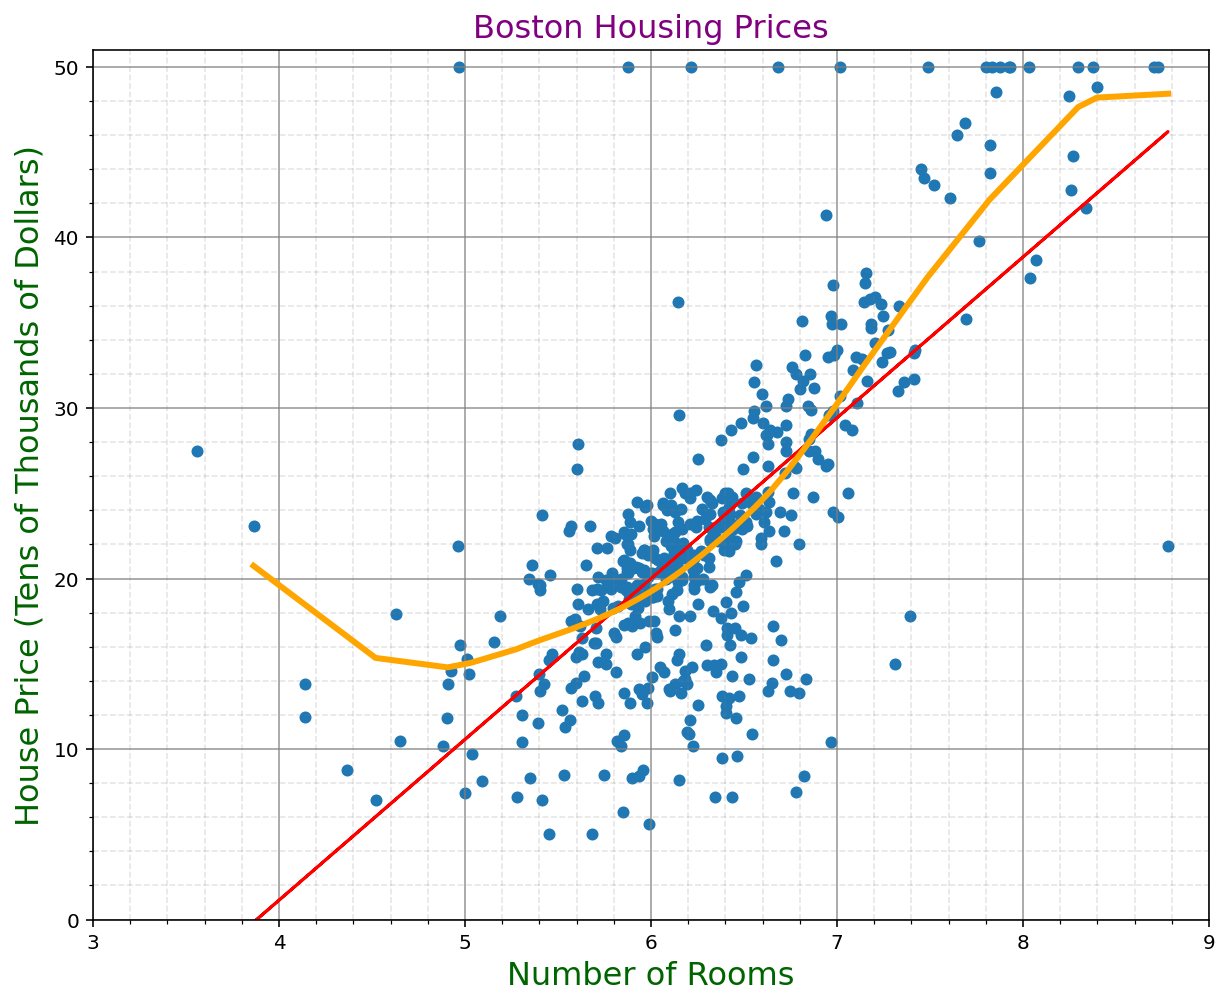

In [ ]:
from sklearn.metrics import mean_absolute_error 

print("Intercept: {:,.3f}".format(lm.intercept_))
print("Coefficient: {:,.3f}".format(lm.coef_[0]))
    
mae = mean_absolute_error(y_test, lm.predict(X_test))
mae_lowess = mean_absolute_error(dat_test[:,1], yhat)
print("MAE = ${:,.2f}".format(1000*mae))
print("MAE LOWESS = ${:,.2f}".format(1000*mae_lowess))
# Plot outputs


fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.plot(X_test, lm.predict(X_test), color='red')
ax.plot(dat_test[:,0], yhat, color='orange',lw=3)
ax.set_xlabel('Number of Rooms',fontsize=16,color='Darkgreen')
ax.set_ylabel('House Price (Tens of Thousands of Dollars)',fontsize=16,color='Darkgreen')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=3)

In [ ]:
rf.fit(X_train,y_train)
yhat_rf = rf.predict(X_test)

In [ ]:
mae_rf = mean_absolute_error(y_test, yhat_rf)
print("MAE RF = ${:,.2f}".format(1000*mae_rf))

MAE RF = $3,973.16


In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=2021)